## Housing Price Prediction Model  
## Course: Big Data Analytics 

 ## A. Setting - up 

### Data analysis libraries   

In [1]:
# Specifying operating system 
import os

# Importing pandas library for data analysis   
import pandas as pd

# Importing numpy library for scientific calculations 
import numpy as np

### Spark - session libraries

In [2]:
# Importing pySpark libraries
# Creating Spark-Session and creating SQL-Context using the Spark-Session   
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

### Machine-learning libraries 

In [3]:
# Importing MLlib libraries for building linear regression model   
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

# Importing MLlib’s tools for optimizing the machine learning algorithm   
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

### Data visualization libraries  

In [4]:
# Importing data visualization libraries

# seaborn
import seaborn as sns

# matplotlib   
import matplotlib.pyplot as plt 

### Customizing the code chunk outputs   

In [5]:
# Setting the output display area of interactive code outputs     
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

# Customizing the matplotlib plotting styles
from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

# Setting the plot outputs to be included in the Jupyter notebook  
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

### Setting random seed for output reproducibility

In [6]:
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed 

 ## B. Creating Spark - Session:

In [7]:
# Retrieving the spark run time directory
os.environ['SPARK_HOME']

# Creating a spark-session and setting name for the application "Linear-Regression-California-Housing"    
spark = SparkSession.builder.master("local[2]").appName("Linear-Regression-California-Housing").getOrCreate()
spark

# Creating Spark-Session and creating SQL-Context using the Spark-Session   
sc = spark.sparkContext
sc
sqlContext = SQLContext(spark.sparkContext)
sqlContext 

'/usr/local/spark'

<SparkContext master=local[2] appName=Linear-Regression-California-Housing>

## C. Loading the dataset 

### Directory path, schema and dataframe 

In [8]:
# Setting the directory path for reading the data file 
HOUSING_DATA = '/home/jovyan/work/cal_housing.data' 

# Defining the schema, corresponding to rows in the .csv data file.
schema = StructType([
                        StructField("long", FloatType(), nullable=True),
                        StructField("lat", FloatType(), nullable=True),
                        StructField("medage", FloatType(), nullable=True),
                        StructField("totrooms", FloatType(), nullable=True),
                        StructField("totbdrms", FloatType(), nullable=True),
                        StructField("pop", FloatType(), nullable=True),
                        StructField("houshlds", FloatType(), nullable=True),
                        StructField("medinc", FloatType(), nullable=True),
                        StructField("medhv", FloatType(), nullable=True)])


# Loading the dataset 
housing_df = spark.read.csv(path = HOUSING_DATA, schema=schema).cache()

## D. Data Exploration

In [9]:
# Show the schema of the data frame
housing_df.printSchema() 

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



In [10]:
# show the data frame columns
housing_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [11]:
# Show first five rows
housing_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [12]:
# Summary and descriptive statistics the dataframe 
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 3).alias("Median Age"),
                    F.round("totrooms", 3).alias("Total Rooms"),
                    F.round("totbdrms", 3).alias("Total Bedrooms"),
                    F.round("pop", 3).alias("Population"),
                    F.round("houshlds", 3).alias("Households"),
                    F.round("medinc", 3).alias("Median Income"),
                    F.round("medhv", 3).alias("Median House Value"))
                    .show())


+-------+----------+-----------+--------------+----------+----------+-------------+------------------+
|summary|Median Age|Total Rooms|Total Bedrooms|Population|Households|Median Income|Median House Value|
+-------+----------+-----------+--------------+----------+----------+-------------+------------------+
|  count|   20640.0|    20640.0|       20640.0|   20640.0|   20640.0|      20640.0|           20640.0|
|   mean|    28.639|   2635.763|       537.898|  1425.477|    499.54|        3.871|        206855.817|
| stddev|    12.586|   2181.615|       421.248|  1132.462|    382.33|          1.9|        115395.616|
|    min|       1.0|        2.0|           1.0|       3.0|       1.0|          0.5|           14999.0|
|    max|      52.0|    39320.0|        6445.0|   35682.0|    6082.0|         15.0|          500001.0|
+-------+----------+-----------+--------------+----------+----------+-------------+------------------+



In [13]:
# Distribution of housingmedianage 
result_df = housing_df.groupBy("medage").count().sort("medage", ascending = False)
result_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



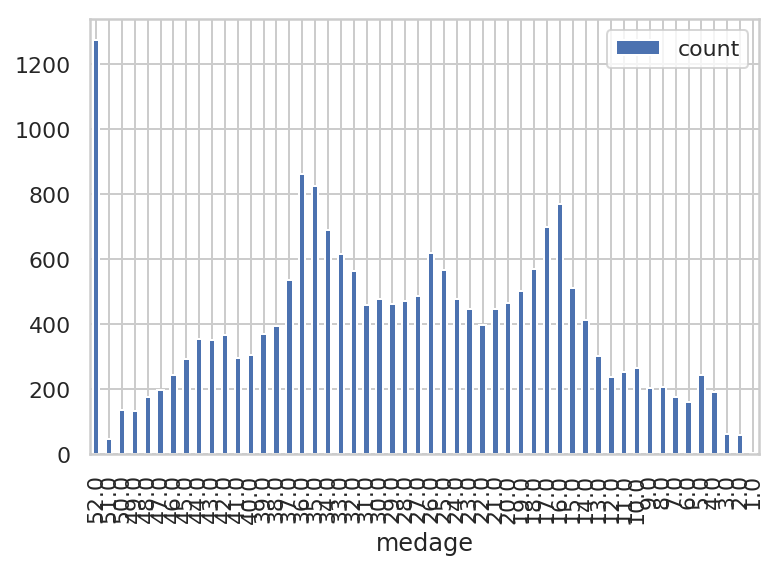

In [14]:
# Plotting the distribution of housingmedianage
result_df.toPandas().plot.bar(x='medage')

## E. Data Pre-processing

In [15]:
# Manipulating the values of `medianHouseValue` column
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)

# The first 2 lines of revised dataframe 
housing_df.show(2) 

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



In [16]:
# Adding new columns to dataframe 
    # rmsperhh = totrooms"/"houshlds
    # popperhh = pop/houshlds
    # bdrmperrm = totbdrms/totrooms

housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# The first 2 lines of revised dataframe 
housing_df.show(5) 

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



## F. Feature Engineering

In [17]:
# Re-order and select columns
housing_df = housing_df.select("medhv", 
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

# put features into a feature vector column
assembler = VectorAssembler(inputCols = featureCols, outputCol = "features")
assembled_df = assembler.transform(housing_df)
assembled_df.show(5, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


In [18]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol = "features_scaled")

# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)

# Inspect the result
scaled_df.select("features", "features_scaled").show(5, truncate=False) 


+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_scaled                                                                                                                       |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

## G. Building a linear regression model 

In [19]:
# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed = rnd_seed)
train_data.columns

# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

# Fit the data to the model
linearModel = lr.fit(train_data) 

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

## H. Evaluating the Model

In [20]:
# Getting the coefficients for the linear regression model
featureCols
linearModel.coefficients

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

DenseVector([0.0, 0.0, 0.0, 0.526, 0.0, 0.0, 0.0])

In [21]:
# Getting the intercept for the linear regression model
linearModel.intercept
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

0.989875772139301

In [22]:
# Predicting the median house values for the test data 
predictions = linearModel.transform(test_data)

# Extracting the predicted and the actual median house values  
predandlabels = predictions.select("predmedhv", "medhv")
predandlabels.show()

+------------------+-----+
|         predmedhv|medhv|
+------------------+-----+
|1.5977678077735522|0.269|
|1.3402962575651638|0.275|
|1.7478926681617617|0.283|
|1.5026315463850333|0.325|
|1.5840068859455108|0.344|
|1.4744173855604754|0.379|
|1.5274954532293994|0.388|
|1.3578228236744827|0.394|
|1.6929041021688493|  0.4|
| 2.010874171848204|  0.4|
|1.3656308740705367| 0.41|
|1.4496919091430263|0.421|
| 1.380970081002033|0.425|
|1.3394379493101451| 0.43|
| 1.722973408950696|0.435|
|1.5529131147882111|0.439|
| 1.323489602290725| 0.44|
|1.4030651812673915|0.444|
|1.5111871672959283|0.446|
|1.5996783060975408| 0.45|
+------------------+-----+
only showing top 20 rows



In [23]:
# Calculating the RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

RMSE: 0.8729980899366503
MAE: 0.6714989215155925


In [24]:
# Getting the R-squared 
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.42213332730120356


In [25]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.9033627063798556


In [26]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.6888437385796472


In [27]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.40877519027090536


In [28]:
# MLlib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)
print("RMSE: {0}".format(metrics.rootMeanSquaredError))
print("MAE: {0}".format(metrics.meanAbsoluteError))
print("R2: {0}".format(metrics.r2))


RMSE: 0.9033627063798556
MAE: 0.6888437385796472
R2: 0.40877519027090536


In [29]:
# Putting the spark session to an end
spark.stop()